
📊 [Auto-Configuration]

+--------------------+----------------+
|     Parameter      | Configuration  |
+--------------------+----------------+
| Dataset Dimensions |    200 × 2     |
|   Missing Values   |     2.50%      |
|    Stationarity    | Non-stationary |
|    Seasonality     |    Present     |
|   Transformation   |      None      |
| Signal Processing  |     lowess     |
|     Imputation     |  interpolate   |
| Outlier Detection  |     tranad     |
| Outlier Threshold  |      3.66      |
|   Decomposition    |    4 bands     |
+--------------------+----------------+
✅ Configuration complete.



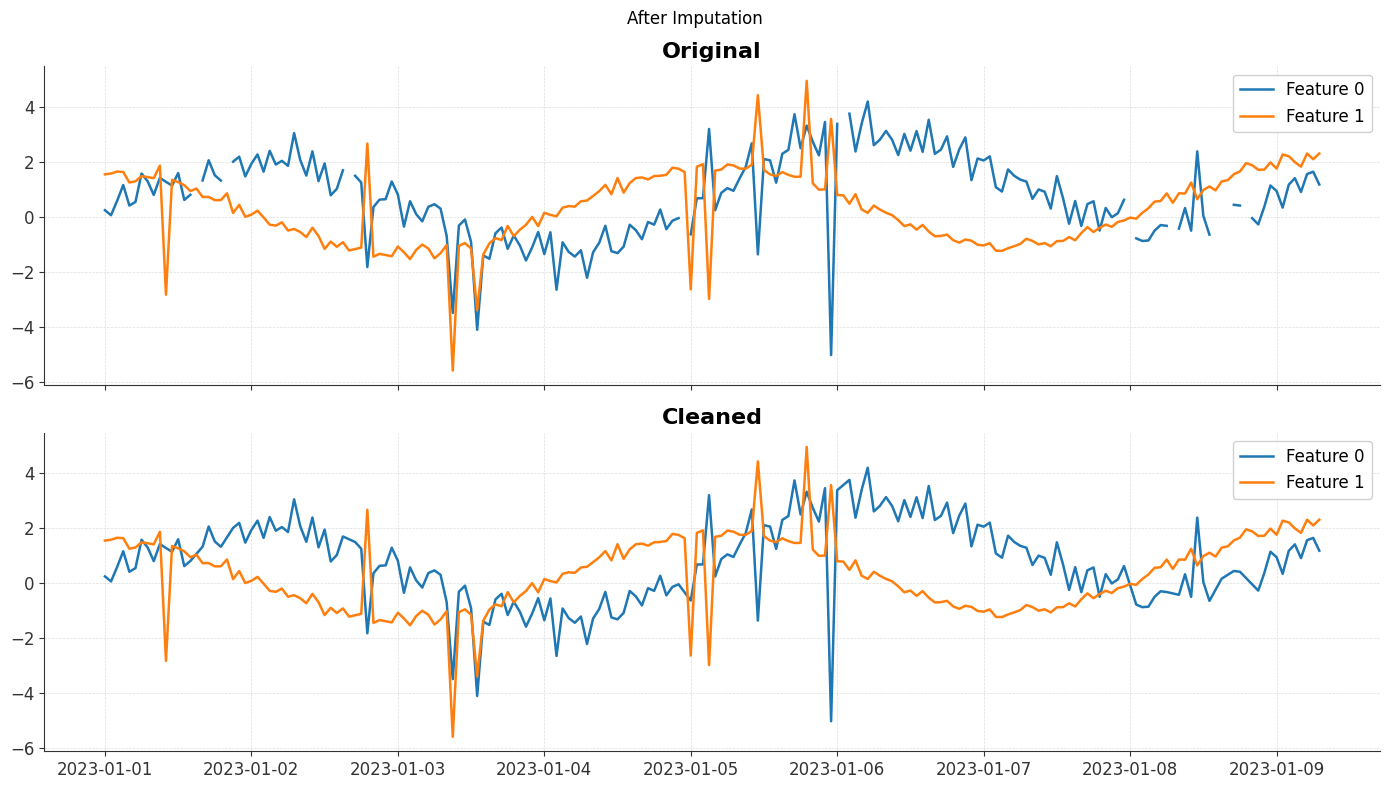

[FeedForwardBlock] Using standard FFN (SwiGLU)
[MultiAttention] Initialized with attention type: standard, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[FeedForwardBlock] Using standard FFN (SwiGLU)
[MultiAttention] Initialized with attention type: standard, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[FeedForwardBlock] Using standard FFN (SwiGLU)
[MultiAttention] Initialized with attention type: standard, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[MultiAttention] Initialized with attention type: standard, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[FeedForwardBlock] Using standard FFN (SwiGLU)
[MultiAttention] Initialized with attention type: standard, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[MultiAttention] Initialized with attention type: standard, available backends: {'flash

Training:   4%|▍         | 20/500 [00:00<00:11, 42.06epoch/s, train_loss=0.253002, val_loss=0.330194]


Early stopping at epoch 21


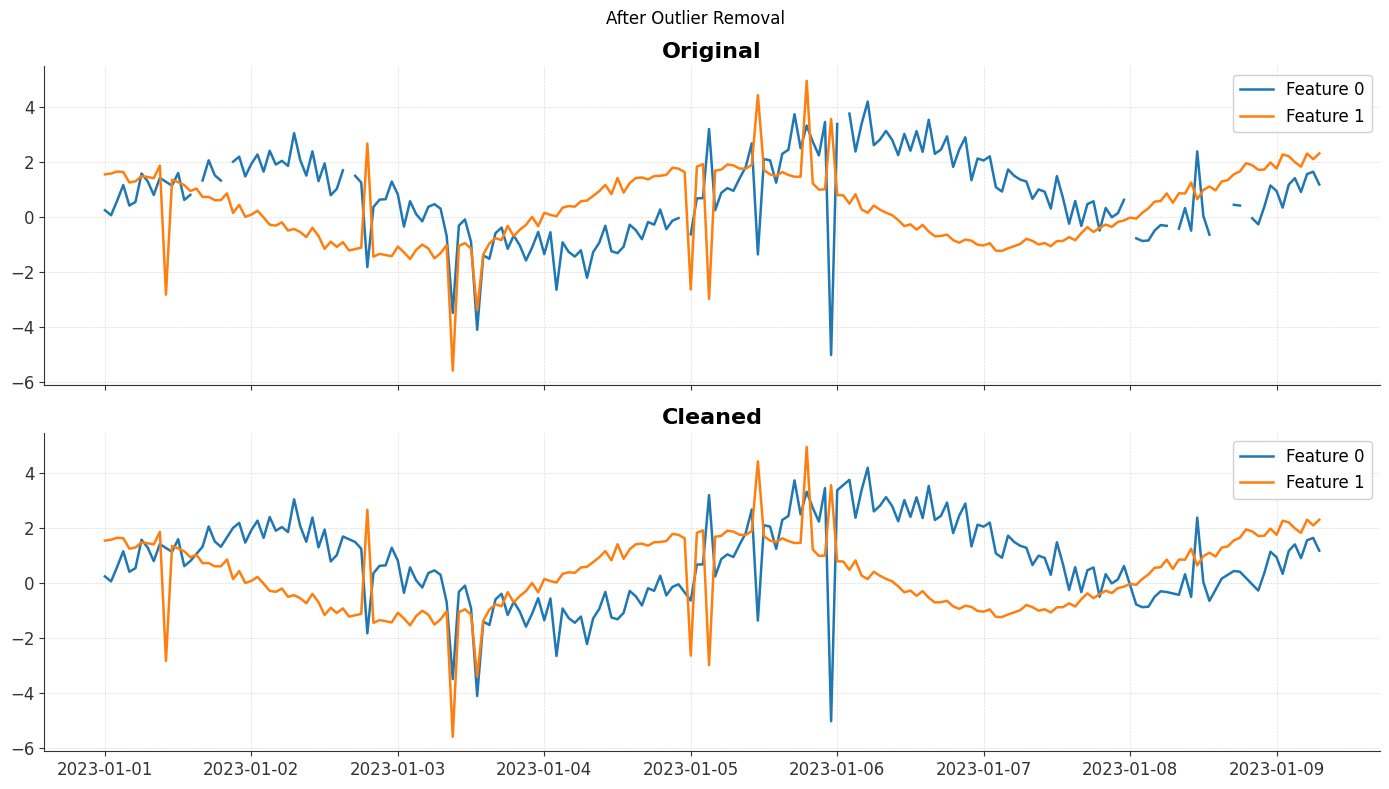

Applying Empirical Wavelet Transform (EWT)...


KeyboardInterrupt: 

In [2]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from foreblocks import TimeSeriesPreprocessor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
n_samples = 200
timestamps = pd.date_range(start='2023-01-01', periods=n_samples, freq='h')

# Create a time series with trend, seasonality, and noise
t = np.linspace(0, 4*np.pi, n_samples)
trend = 0.1 * t
seasonality1 = 2 * np.sin(t)  # Daily pattern
seasonality2 = 1 * np.sin(t/24)  # Weekly pattern
noise = np.random.normal(0, 0.5, n_samples)

# Combine components
data = (trend + seasonality1 + seasonality2 + noise).reshape(-1, 1)

# Create a second feature (to demonstrate multivariate capabilities)
data2 = (0.5 * trend + 1.5 * np.cos(t) + 0.5 * np.random.normal(0, 0.3, n_samples)).reshape(-1, 1)
data = np.hstack([data, data2])  # Now we have shape [n_samples, 2]

# Add some outliers
outlier_indices = np.random.choice(n_samples, 10, replace=False)
data[outlier_indices] = data[outlier_indices] + 5 * np.random.randn(10, 2)

# Add some missing values (but not too many)
missing_indices = np.random.choice(n_samples, 10, replace=False)
data[missing_indices, 0] = np.nan  # Only make some values missing in first feature

# Create preprocessor with various techniques enabled
preprocessor = TimeSeriesPreprocessor(
    normalize=True,
    differencing=False,
    detrend=True,
    apply_ewt=True,
    window_size=24,
    horizon=12,
    remove_outliers=True,
    outlier_threshold=0.05,
    outlier_method="iqr",
    impute_method="iterative",
    ewt_bands=5,
    trend_imf_idx=0,
    log_transform=False,
    filter_window=5,
    filter_polyorder=2,
    apply_filter=True,
    self_tune=True,
    apply_imputation=True,
)

# Fit and transform the data
X, y, processed_data, _ = preprocessor.fit_transform(data, time_stamps=timestamps)

# Visualize the results
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.title('Original Data with Outliers and Missing Values')
plt.plot(data)

plt.subplot(3, 1, 2)
plt.title('Processed Data')
print("Processed data shape:", processed_data.shape)
plt.plot(processed_data)

plt.subplot(3, 1, 3)
plt.title('EWT Components')
ewt_components = preprocessor.get_ewt_components()
if ewt_components:
    for i, imf in enumerate(ewt_components[0].T):
        plt.plot(imf, label=f'IMF {i}')
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Input sequence shape: {X.shape}")
print(f"Target sequence shape: {y.shape}")

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── Fix path ─────────────────────────────
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ─── Synthetic time series ────────────────
np.random.seed(42)
n_samples = 200
timestamps = pd.date_range(start='2023-01-01', periods=n_samples, freq='h')

t = np.linspace(0, 4 * np.pi, n_samples)
trend = 0.1 * t
seasonality1 = 2 * np.sin(t)
seasonality2 = 1 * np.sin(t / 24)
noise = np.random.normal(0, 0.5, n_samples)
data = (trend + seasonality1 + seasonality2 + noise).reshape(-1, 1)

# ─── Import feature extractor ─────────────
from foreblocks.ts_fengine import SignalProcessor

fengine = SignalProcessor()

# ─── Feature extraction ───────────────────
window_size = 48
step_size = 24
signals = {'signal': data.flatten()}
labels = {'signal': 0}  # dummy label

features, feature_labels, raw_windows, window_labels = fengine.process_signals(
    signals, labels, window_size=window_size, step_size=step_size, augment=True
)

selected_names = fengine.get_selected_feature_names()
print(f"Selected {len(selected_names)} features:")
print(selected_names)

# ─── Create dataframe ─────────────────────
feature_names = fengine.feature_engineer.get_feature_names()
features_df = pd.DataFrame(features, columns=feature_names)
#features_df.index = timestamps[window_size - 1::step_size][:len(features_df)]

# ─── Display ──────────────────────────────
print(features_df.head())
print(feature_names[:5], "...")  # preview names


NameError: name 'ImprovedSignalGAN' is not defined

In [ ]:
import os
notebook_dir = os.getcwd()
import sys
print(f"Current notebook directory: {notebook_dir}")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
print(f"Parent directory: {parent_dir}")
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    # add parent_dir / foretools to sys.path
    foretools_dir = os.path.join(parent_dir, 'foretools')
    if foretools_dir not in sys.path:
        sys.path.append(foretools_dir)
        print(f"Added {foretools_dir} to sys.path")


from foreminer import *

Current notebook directory: /home/seman/baseline/foreblocks/examples
Parent directory: /home/seman/baseline/foreblocks
Added /home/seman/baseline/foreblocks/foretools to sys.path


In [1]:
import os
notebook_dir = os.getcwd()
import sys

from foretools.foreminer.foreminer import *
import numpy as np
import pandas as pd

def generate_synthetic_dataset(n_samples=1000, seed=42) -> pd.DataFrame:
    np.random.seed(seed)

    # Time column
    time = pd.date_range(start="2022-01-01", periods=n_samples, freq="H")

    # Numeric features
    x1 = np.random.normal(loc=50, scale=10, size=n_samples)
    x2 = 2 * x1 + np.random.normal(0, 5, n_samples)  # strong linear correlation
    x3 = np.random.exponential(scale=1.0, size=n_samples)  # skewed
    x4 = np.sin(np.linspace(0, 20 * np.pi, n_samples)) + np.random.normal(0, 0.2, n_samples)  # seasonal
    x5 = np.random.poisson(lam=5, size=n_samples).astype(float)  # count-like (converted to float to allow NaNs)
    x6 = np.random.beta(2, 5, size=n_samples)  # bounded [0, 1]
    x7 = np.random.lognormal(mean=2, sigma=0.8, size=n_samples)  # log-normal candidate
    x8 = x3 ** 2 + np.random.normal(0, 0.5, n_samples)  # non-linear relation with x3

    # Categorical features
    cat1 = np.random.choice(['A', 'B', 'C'], size=n_samples, p=[0.5, 0.3, 0.2])
    cat2 = np.random.choice([f"Category_{i}" for i in range(20)], size=n_samples)

    # Introduce missing values (5% in some columns)
    for arr in [x3, x5, x6]:
        mask = np.random.rand(n_samples) < 0.05
        arr[mask] = np.nan

    # Inject outliers in x1
    outlier_indices = np.random.choice(n_samples, size=10, replace=False)
    x1[outlier_indices] += np.random.normal(100, 10, size=10)

    # Assemble dataframe
    df = pd.DataFrame({
        'timestamp': time,
        'x1_normal': x1,
        'x2_linear_combo': x2,
        'x3_skewed': x3,
        'x4_seasonal': x4,
        'x5_count': x5,
        'x6_bounded': x6,
        'x7_lognorm': x7,
        'x8_nonlinear': x8,
        'category_low_card': cat1,
        'category_high_card': cat2
    })

    return df


df = generate_synthetic_dataset(n_samples=1500)
analyzer = DatasetAnalyzer(df, time_col='timestamp')
analyzer.analyze_everything()


🔍 Initialized analyzer with 1,500 rows × 10 columns
   • Numeric features: 8
   • Categorical features: 2
🔍 🚀 Starting comprehensive dataset analysis...
🔍 Running distributions analysis...
🔍 Running correlations analysis...
🔍 Running outliers analysis...
🔍 Running clusters analysis...
🔍 Running dimensionality analysis...
🔍 Running patterns analysis...
🔍 Running missingness analysis...
🔍 Running feature_engineering analysis...
🔍 Running shap_explanation analysis...
🔍 Running categorical_groups analysis...
🔍 Running graph_analysis analysis...
🔍 Running timeseries analysis...
interval columns not set, guessing: ['x1_normal', 'x2_linear_combo', 'x3_skewed', 'x4_seasonal', 'x5_count', 'x6_bounded', 'x7_lognorm', 'x8_nonlinear']

📊 EXECUTIVE SUMMARY
Dataset Overview:
• Shape: 1,500 rows × 10 columns 
• Memory Usage: 0.29 MB 
• Numeric Features: 8 
• Categorical Features: 2 
• Missing Values: 1.61% 🟡

📊 DISTRIBUTION ANALYSIS
Statistical Properties:
• Normal Distributions: 1/8 (12.5%) 
• Skewe